In [1]:
import os; os.chdir("..")

In [3]:
%load_ext autoreload
# %load_ext juypter_black
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urbanstats.games.quiz_analysis import get_full_statistics, questions
from urbanstats.games.quiz_question_distribution import compute_difficulty
from urbanstats.games.quiz import (
    display_question,
    stats_to_display,
    renamed,
    get_statistic_categories,
    ranges,
)
from urbanstats.statistics.output_statistics_metadata import internal_statistic_names

In [6]:
text_to_col = {q : k for k, q in stats_to_display.items()}
text_to_col.update(renamed)
text_to_col = {k.lower(): v for k, v in text_to_col.items()}
text_to_col.update({k.split("!tooltip")[0].strip(): v for k, v in text_to_col.items()})

bad = set(text_to_col.values()) - set(internal_statistic_names())
assert not bad, bad

In [7]:
 # plt.rcParams["font.family"] = "monospace"

In [8]:
result = get_full_statistics(after_problem=1, debug=False)
num_users_by_problem = result.groupby("problem").count().user_id
means = result[["problem", "score", *questions]].groupby("problem").mean()

/home/kavi/anaconda3/envs/urbanstats-310/lib/python3.10/site-packages/pandas/core/tools/datetimes.py:528: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


In [65]:
qdata = []
for problem in means.index:
    with open(f"/home/kavi/temp/site/quiz/{problem}") as f:
        quiz_qns = json.load(f)
    for qcol, q in zip(questions, quiz_qns):
        qn = q["question"].lower()
        qn = qn.split("!tooltip")[0].strip()
        if "dewpoint" in qn or "hawaiian" in qn or "native" in qn.lower() or "area" in qn:
            continue
        sl, sh = q["stat_a"], q["stat_b"]
        if sl > sh:
            sh, sl = sl, sh
        if qn not in text_to_col:
            print(repr(qn))
            continue
        qdata.append(dict(
            a=q["longname_a"],
            b=q["longname_b"],
            error_rate=1-means.loc[problem, qcol],
            col=text_to_col[qn],
            stat_high=sh,
            stat_low=sl,
            quiz_number=problem,
            question_index=int(qcol[1:])
        ))

In [96]:
qdata_recent = qdata[qdata.quiz_number > 300]
qdata_recent.pivot_table(index="question_index", columns="question_index_imputed", aggfunc='count')["a"].fillna(0).astype(int)

question_index_imputed,0,1,2,3,4,5
question_index,,,,,,
1,15,166,0,0,0,0
2,4,21,152,0,0,0
3,7,9,13,148,0,0
4,6,5,8,8,152,0
5,0,3,2,3,12,161


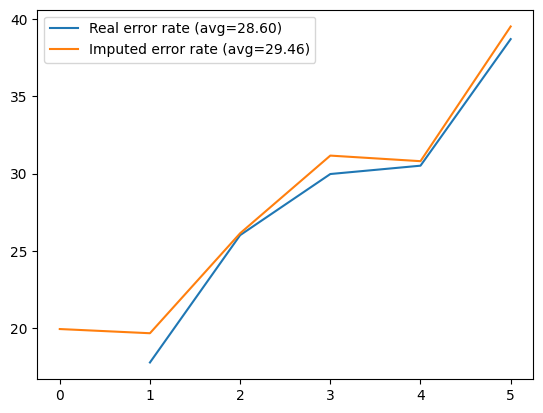

In [97]:
error_rate_real = 100 * qdata_recent.groupby("question_index").mean().error_rate
error_rate_imputed = 100 * qdata_recent.groupby("question_index_imputed").mean().error_rate

plt.plot(error_rate_real, label=f"Real error rate (avg={error_rate_real.mean():.2f})")
plt.plot(error_rate_imputed, label=f"Imputed error rate (avg={error_rate_imputed[error_rate_imputed.index != 0].mean():.2f})")
plt.legend()

In [98]:
agg = qdata[["col", "residuals"]].groupby("col").agg(["mean", "count"])
agg["abs_mean"] = np.abs(agg[('residuals', 'mean')])
agg = agg[agg['residuals', 'count'] > 10].sort_values("abs_mean")
for x in [*agg.index[::-1][:20]]:
    name = stats_to_display[x].split("!TO")[0]
    if name.startswith("!FULL"):
        name = name[6:]
    else:
        name = f"Which has a {name}?"
    print(name)
    score = agg.iloc[list(agg.index).index(x)]['residuals', 'mean']
    print(f"d.r.e. {score:+.2f}: ({np.exp(score) - 1:+.0%})")

Which has a higher % of residents who are citizens by birth?
d.r.e. -0.58: (-44%)
Which has a higher % of days with wind speed over 10mph (population weighted)?
d.r.e. +0.48: (+62%)
Which has a higher mean daily high heat index (population weighted)?
d.r.e. -0.41: (-34%)
Which has less exposure to active EPA superfund sites (higher population-weighted mean distance)?
d.r.e. +0.40: (+50%)
Which has a larger % of homes heated using electricity?
d.r.e. +0.39: (+47%)
Which has a higher mean daily high temperature (population weighted)?
d.r.e. -0.37: (-31%)
Which has a higher % of people who commute by car?
d.r.e. -0.34: (-29%)
Which has a higher % of people who only speak english at home?
d.r.e. -0.34: (-28%)
Which has a higher % of people who were born in the US and outside their state of residence?
d.r.e. +0.32: (+38%)
Which has a higher % of people who have commute time under 15 min?
d.r.e. +0.31: (+37%)
Which has a higher % of units that are vacant?
d.r.e. +0.30: (+35%)
Which has a hig

In [ ]:
u = qdata[qdata.delta == qdata.delta].groupby("cat").mean().sort_values("delta")["delta"]
for i in u.index:
    print(i, u[i])

In [100]:
qdata[qdata.diffi > ranges[0][-1]]

,a,b,error_rate,col,stat_high,stat_low,quiz_number,question_index,log_diff,pct_diff,diffi,delta,residuals,question_index_imputed
4,"Wyoming, USA","District of Columbia, USA",0.010309,density_2021_pw_1_canada,6569.571122,623.974795,3,2,2.354094,9.528584,3811.433653,NaN,-0.552242,0
7,"St. Louis city-County, Missouri, USA","Loudoun County, Virginia, USA",0.124260,asian,0.212296,0.040470,4,1,1.657409,4.245701,566.093484,NaN,0.042449,0
13,"Ponce MSA, PR, USA","Montgomery MSA, AL, USA",0.198925,household_income_over_100k,0.241635,0.031979,5,2,2.022342,6.555998,1092.666314,NaN,0.312274,0
36,"Oklahoma, USA","Hawaii, USA",0.033333,rent_1br_over_1500,0.382902,0.032880,10,1,2.454913,10.645421,709.694750,NaN,-0.421937,0
43,"Laredo [Urban Area], TX, USA","Dallas-Fort Worth-Arlington [Urban Area], TX, USA",0.028169,asian,0.082186,0.005122,11,3,2.775426,15.045464,2006.061844,NaN,-0.354142,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2230,"Indiana, USA","Arizona, USA",0.023920,rainfall_4,0.997853,0.237740,463,1,1.434429,3.197249,1065.749772,NaN,-0.480206,0
2302,"Madison city, Wisconsin, USA","Stockton city, California, USA",0.527048,"industry_agriculture,_forestry,_fishing_and_hu...",0.042558,0.002846,477,4,2.705032,13.954795,697.739737,NaN,0.669245,0
2310,"DC Circuit, USA","7th Circuit, USA",0.077844,sors_cohabiting_partnered_gay,0.023260,0.005613,479,2,1.421644,3.143927,628.785360,NaN,-0.129362,0
2324,"CA-28, USA","NC-06, USA",1.000000,wind_speed_over_10mph_4,0.060466,0.000646,748,1,4.538999,92.597098,30865.699404,NaN,1.391787,0


In [101]:
qdata[qdata.diffi < ranges[-1][0]]

,a,b,error_rate,col,stat_high,stat_low,quiz_number,question_index,log_diff,pct_diff,diffi,delta,residuals,question_index_imputed
30,"Austin [Urban Area], TX, USA","Allentown-Bethlehem [Urban Area], PA-NJ, USA",0.557971,transportation_means_car,0.855045,0.769188,8,5,0.105819,0.111621,3.720694,NaN,0.074482,0
80,"Vermont, USA","Illinois, USA",0.539683,insurance_coverage_private,0.738698,0.706554,19,4,0.044489,0.045493,2.274671,NaN,0.002064,0
86,"Pennsylvania, USA","Texas, USA",0.614679,housing_per_pop,0.553602,0.529374,20,5,0.044751,0.045767,3.051142,NaN,0.092346,0
177,"Jacksonville FL Media Market, USA","Dothan AL Media Market, USA",0.284375,transportation_means_car,0.940035,0.861313,39,5,0.087459,0.091397,3.046574,NaN,-0.234587,0
199,"Greensboro city, North Carolina, USA","Long Beach city, California, USA",0.333333,transportation_means_walk,0.025173,0.022454,44,5,0.114307,0.121096,4.036533,NaN,-0.134492,0
237,"Lafayette LA Media Market, USA","Minot-Bismarck-Dickinson ND Media Market, USA",0.108312,language_english_only,0.944600,0.901838,52,5,0.046327,0.047417,3.161103,NaN,-0.626093,0
